In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose,LeakyReLU, Dropout,BatchNormalization
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from google.colab import drive
from PIL import Image
import os
import random


**Data Processing**

In [ ]:
path = r'/content/drive/MyDrive/CryptoPunks'
filelist = os.listdir(path)
lst = []
for file in filelist:
  img = Image.open(path+'/'+file)
  img = img.convert('RGB')
  arr = np.array(img)
  lst.append(arr)

In [44]:
x_train = lst[:8000]
x_train = np.array(x_train)

x_test = lst[8000:10000]
x_test = np.array(x_test)

y_train = [1] * 8000
y_test = [1] * 2000

y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(x_train),len(x_test))
print(x_train.shape,y_train.shape,type(x_train),type(y_train))

print(x_train.min(),x_train.max())
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(x_train.min(),x_train.max())
print(x_train.shape)

8000 2000
(8000, 24, 24, 3) (8000,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
0 255
-1.0 1.0
(8000, 24, 24, 3)


In [45]:
def display_images(images):
  for i in range(20):    
    plt.subplot(4, 5, i + 1)
    img = np.uint8(images[i] * 127.5 + 127.5) #revert to 0..255
    plt.imshow(img.reshape(24,24,3))      
  plt.show()

In [46]:
D_loss=[] #list to collect loss for the discriminator model
D_acc=[] #list to collect accuracy for the discriminator model
G_loss=[] #list to collect loss for generator model

**Discriminator**

In [47]:
discriminator = Sequential()
in_shape = (24,24,3)
discriminator.add(Conv2D(64, (2,2), padding='same', input_shape=in_shape))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation=tf.keras.layers.LeakyReLU()))
opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [48]:
discriminator.trainable = False
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 64)        832       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        16448     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 12, 12, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 64)          16448     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 6, 6, 64)          0         
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 64)         

**Generator**

In [49]:
latent_dim = 32
generator = Sequential()
generator.add(Dense(6 * 6 * 128, input_shape=[latent_dim]))
generator.add(Reshape([6, 6, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",activation=LeakyReLU()))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same",activation="tanh"))

In [50]:
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4608)              152064    
                                                                 
 reshape_3 (Reshape)         (None, 6, 6, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 6, 6, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 12, 12, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                     

**GAN**

In [51]:
RMS = tf.keras.optimizers.RMSprop(lr = .0001,clipvalue=1.0,decay=1e-8)
GAN = Sequential([generator,discriminator])
GAN.compile(loss='binary_crossentropy',optimizer = RMS)
GAN.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 24, 24, 3)         362499    
                                                                 
 sequential_9 (Sequential)   (None, 1)                 50753     
                                                                 
Total params: 413,252
Trainable params: 362,115
Non-trainable params: 51,137
_________________________________________________________________


In [52]:
batch_size = 16
epochs = 25
my_data = x_train

zeros=np.zeros(shape=(batch_size,1))
ones=np.ones(shape=(batch_size,1))

len(my_data) / batch_size

500.0

In [53]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
print(my_data.shape)
print(x_train.shape)
print(dataset)

(8000, 24, 24, 3)
(8000, 24, 24, 3)
<PrefetchDataset element_spec=TensorSpec(shape=(16, 24, 24, 3), dtype=tf.float64, name=None)>


In [54]:
noise = tf.random.normal(shape=[20, latent_dim])
images = generator(noise)
print(type(noise),type(images))
print(images)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[[ 1.68811169e-03  4.08535823e-03 -1.48764614e-03]
   [-2.86766118e-03  1.26722846e-02 -1.11212460e-02]
   [ 7.22894911e-03  2.68054544e-03  1.06780566e-02]
   ...
   [-2.50390731e-05  1.08634569e-02 -8.20468832e-03]
   [-1.36566802e-03  1.43524325e-02 -7.76204746e-03]
   [-3.67933000e-03 -6.45933859e-03 -6.53500017e-03]]

  [[-4.87877987e-05  7.74970092e-03  8.24202690e-03]
   [ 6.93206023e-03 -5.44047588e-03  3.35446969e-02]
   [ 2.26893555e-03 -1.67462919e-02  1.43410545e-02]
   ...
   [ 6.52809022e-03 -1.60335340e-02  4.07922408e-03]
   [-1.10064670e-02  1.53283905e-02  9.70577914e-03]
   [-6.91262307e-03  4.75136563e-03  9.58213676e-03]]

  [[ 1.30925523e-02  6.59946585e-03 -4.66711732e-04]
   [ 2.15149578e-03 -5.28710103e-03 -5.07545285e-03]
   [ 2.72782557e-02 -3.06680403e-03 -5.00906864e-03]
   ...
   [-1.51050892e-02 -1.87152270e-02 -2.46006530e-02]
   [ 1.0

**Training**

Epoch # 1


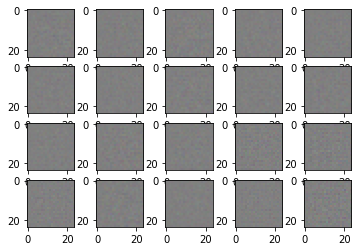

real: (16, 24, 24, 3) (16, 1)
gen:  (16, 24, 24, 3) (16, 1)
combined:  (32, 24, 24, 3) (32, 1)
noise:  (16, 32) (16, 1)
d_loss: 0.10521277785301208 d_acc: 0.96875 g_loss: 12.733010292053223
Epoch # 2


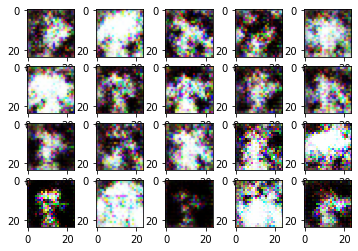

d_loss: 3.4944562911987305 d_acc: 0.6875 g_loss: 10.886579513549805
Epoch # 3


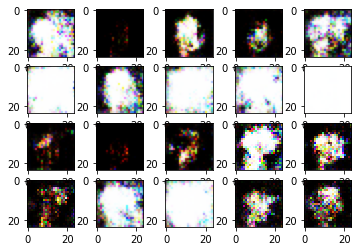

d_loss: 0.2437545508146286 d_acc: 0.90625 g_loss: 9.35212516784668
Epoch # 4


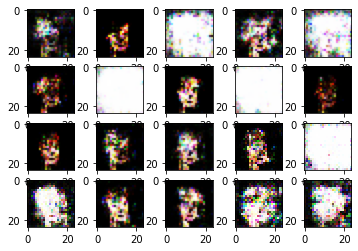

d_loss: 4.7400407791137695 d_acc: 0.46875 g_loss: 6.041654586791992
Epoch # 5


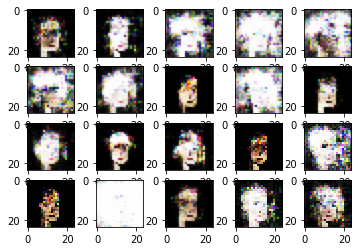

d_loss: 0.38530653715133667 d_acc: 0.75 g_loss: 5.434708118438721
Epoch # 6


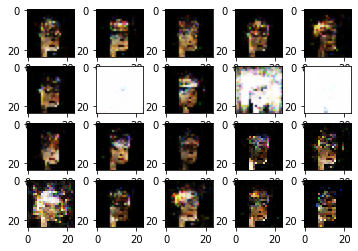

d_loss: 0.2645062506198883 d_acc: 0.9375 g_loss: 4.687119483947754
Epoch # 7


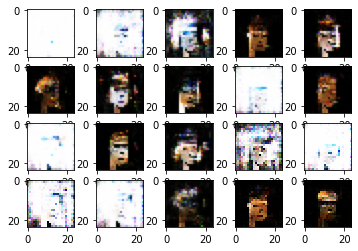

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 8


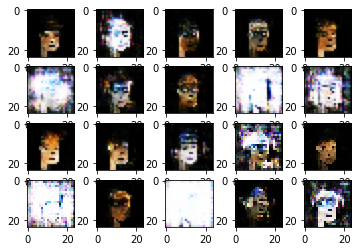

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 9


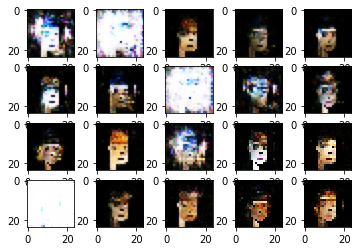

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 10


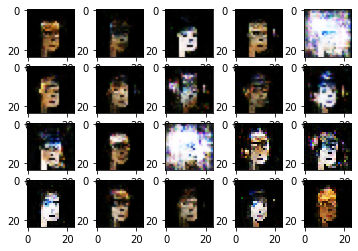

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 11


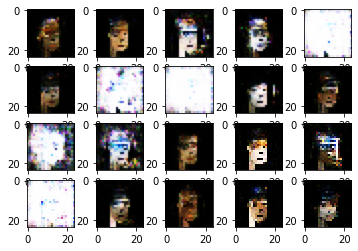

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 12


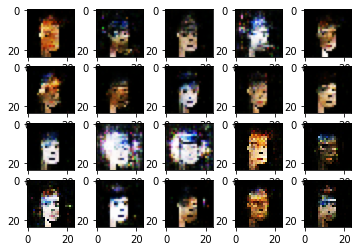

d_loss: 7.712474346160889 d_acc: 0.5 g_loss: 15.424948692321777
Epoch # 13


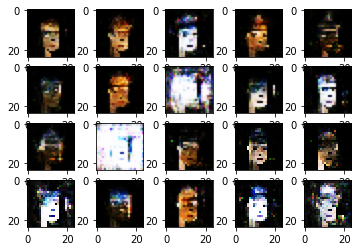

KeyboardInterrupt: ignored

In [55]:
for epoch in range(epochs):

    #display plots
    print(f"Epoch # {epoch+1}")
    noise = tf.random.normal(shape=[20, latent_dim])
    images = generator(noise)
    display_images(images)    

    i = 0    
    for X_batch in dataset:
        i=i+1

        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        real_images = tf.dtypes.cast(X_batch,tf.float32)        
        noise = tf.random.normal(shape=[batch_size, latent_dim])
        fake_images = generator(noise)   

        combined_images = np.concatenate([real_images,fake_images],axis=0)  # problem is real_images is shaped as (16,24,24,1) instead of (16,24,24,3) 
        combined_labels = np.concatenate([ones,zeros],axis=0)
        
        d_loss, d_acc = discriminator.train_on_batch(combined_images, combined_labels)
                
        #####################################
        ## TRAINING THE GENERATOR ##########
        ###################################
        
        noise = tf.random.normal(shape=[batch_size, latent_dim])  
        g_loss = GAN.train_on_batch(noise, ones)
        
        #print shape info 
        if epoch==0 and i==1:
          print("real:" ,real_images.shape, ones.shape)
          print("gen: ", fake_images.shape, zeros.shape)
          print("combined: ",combined_images.shape,combined_labels.shape)
          print("noise: ", noise.shape, ones.shape)
        
        #append loss & accuracy 
        if i%50==49:
          D_loss.append(d_loss)
          D_acc.append(d_acc)          
          G_loss.append(g_loss)    
    
    #print loss and accuracy 
    print(f"d_loss: {d_loss} d_acc: {d_acc} g_loss: {g_loss}")    
      
print("TRAINING COMPLETE")            